# 울산 주차문제 해결을 위한 노상주차장 최적 입지 선정
 
## # 울산 중구 주정차단속 현황 추세 분석
---

* **추세 분석** : 불법주정차와 관련하여 비슷한 패턴과 추세를 가지는 행정동을 우선적으로 파악하기 위하여 2019/01/01부터 2020/10/31까지의 울산광역시 중구 불법주정차 단속 현황 데이터를 활용하여 행정동별 클러스터링을 진행한다. 이후에는 클러스터링 된 결과물을 활용하여 우선 설치 대상 행정동을 선정한다.


* **입지 분석** : 선정된 지역을 동일한 간격의 격자(100*100M)로 나누고, 각 격자의 중심점으로부터 가장 가까운 시설물의 거리를 값으로 산출한다. 단속건수에 대한 값은 중구 지역 단속건수 TOP100 지역으로 기간 내 월평균 5회 이상 단속이 일어난 구역으로 설정하였다. 노상주차장 설치 가능 구역으로 나눈 격자에 산출한 결과를 대입하여 최종적으로 입지를 선정한다.

![분석프로세스](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FHv5eC%2FbtriHB9BnhQ%2FSal6SE1zJPHx6krjd2W1u1%2Fimg.png)


* **추세 분석 활용 데이터** : 공공데이터포털에서 제공하는 울산광역시 중구_불법주정차단속정보 데이터로, 2018/01/01부터 2020/11/22까지의 울산시 중구 내 불법주정차 단속현황 정보가 포함되어있다.



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
import platform
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt

plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\malgun.ttf').get_name()
    rc('font', family=font_name)

# 1. 데이터 전처리
- 울산 중구 불법주정차 데이터를 2019-01-01~ 2020-10-31까지로 맞춰준 다음, 주 단위 컬럼을 생성하였다.
- 최종적으로 행정동, 주, 주별 일일단속건수의 평균, MinMax Scaling을 통한 주별 일일단속건수의 평균 정규화 컬럼으로 구성된 데이터프레임 생성하였다.

In [3]:
df = pd.read_csv("./중구_불법주정차_동별포함최종.csv", encoding='euc-kr')

In [4]:
cc= df.loc[(df["불법주정차 단속일"]>="2019-01-01") &(df["불법주정차 단속일"]<="2020-10-31")]
cc

,시도,시군구,불법주정차 단속일,불법주정차 단속 위치,단속건수,견인 건수,데이터 기준일,행정동
0,울산광역시,중구,2019-01-01,우정동 아이파크 뒤(북부,1,0,2020-11-22,우정동
1,울산광역시,중구,2019-01-01,우정동 아이파크 뒤(북부,1,0,2020-11-22,우정동
2,울산광역시,중구,2019-01-01,우정동 아이파크 뒤(북부,1,0,2020-11-22,우정동
3,울산광역시,중구,2019-01-01,남외동 삼일아파트 앞(번,1,0,2020-11-22,남외동
4,울산광역시,중구,2019-01-01,남외동 삼일아파트 앞(번,1,0,2020-11-22,남외동
...,...,...,...,...,...,...,...,...
88050,울산광역시,중구,2020-10-31,태화동 태화강국가정원길,1,0,2020-11-22,태화동
88051,울산광역시,중구,2020-10-31,태화동 태화강국가정원길,1,0,2020-11-22,태화동
88052,울산광역시,중구,2020-10-31,태화동 태화강국가정원길,1,0,2020-11-22,태화동
88053,울산광역시,중구,2020-10-31,태화동 신기9길,1,0,2020-11-22,태화동


In [5]:
print(">> 중구 행정동 정보 : ",cc["행정동"].unique())
print(">> 중구 행정동 개수 : ",len(cc["행정동"].value_counts()))

>> 중구 행정동 정보 :  ['우정동' '남외동' '태화동' '서동' '옥교동' '성남동' '성안동' '북정동' '학산동' '복산동' '학성동' '약사동'
 '반구동' '다운동' '동동' '교동' '유곡동' '장현동']
>> 중구 행정동 개수 :  18


#### * 어떤 행정동은 어떤 날에 단속건수가 없는 날도 있기 때문에 단속건수가 없는 날은 0으로 데이터를 채움

In [6]:
# 데이터에서 2019-01-01~20201031 기간 동안 존재하는 날짜 개수 : 666
len(cc["불법주정차 단속일"].unique())

666

In [7]:
# 2019-01-01~2020-10-31 기간 날짜 개수 : 670
date = pd.date_range('2019-01-01','2020-10-31')
len(date)

670

In [8]:
category = list(set(cc["행정동"].unique()))

In [9]:
len(category)

18

In [10]:
item = [date, category]
item[0][:5]

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05'],
              dtype='datetime64[ns]', freq='D')

#### * 조합을 구하는 product 함수로 빠져있는 날짜를 포함해서 데이터 프레임 생성

In [11]:
# 조합을 구하는 product 함수로 빠져있는 날짜를 포함해서 데이터 프레임 생성
from itertools import product
dong_temp = pd.DataFrame(product(*item), columns= ['위반일자','행정동'])
dong_temp

,위반일자,행정동
0,2019-01-01,학산동
1,2019-01-01,약사동
2,2019-01-01,다운동
3,2019-01-01,남외동
4,2019-01-01,장현동
...,...,...
12055,2020-10-31,학성동
12056,2020-10-31,우정동
12057,2020-10-31,옥교동
12058,2020-10-31,성안동


In [12]:
cc = cc.drop(["시도","시군구","견인 건수","데이터 기준일"], axis=1)

In [13]:
cc.columns=["위반일자", "위반장소명","단속건수","행정동"]

In [14]:
dong_temp["위반일자"] = dong_temp["위반일자"].astype('str')

In [15]:
col_list = ['위반일자','행정동','단속건수']
dong_ju = pd.merge(cc[col_list],dong_temp,on=['위반일자','행정동'], how='right')

In [16]:
# 단속건수가 없는 날은 0으로 채워줌
dong_ju = dong_ju.fillna(0)

In [17]:
dong_ju

,위반일자,행정동,단속건수
0,2019-01-01,우정동,1.0
1,2019-01-01,우정동,1.0
2,2019-01-01,우정동,1.0
3,2019-01-01,우정동,1.0
4,2019-01-01,우정동,1.0
...,...,...,...
91453,2020-10-31,다운동,0.0
91454,2020-10-31,장현동,0.0
91455,2020-10-31,북정동,0.0
91456,2020-10-31,교동,0.0


In [18]:
djc = dong_ju.copy()

In [19]:
djc = djc.sort_values(by=["행정동","위반일자"])

In [20]:
djc

,위반일자,행정동,단속건수
88059,2019-01-01,교동,0.0
88064,2019-01-02,교동,0.0
88067,2019-01-03,교동,0.0
570,2019-01-04,교동,1.0
571,2019-01-04,교동,1.0
...,...,...,...
88012,2020-10-31,학성동,1.0
88013,2020-10-31,학성동,1.0
88014,2020-10-31,학성동,1.0
88015,2020-10-31,학성동,1.0


#### * 데이터에 주 컬럼을 추가로 생성

In [21]:
import datetime as dt
djc['주'] = pd.to_datetime(djc['위반일자']).dt.week 

In [22]:
djc1 = djc[(djc["위반일자"] >= '2019-01-01') & (djc["위반일자"] <= '2019-12-29')]

In [23]:
djc2 =djc[(djc["위반일자"] >= '2019-12-30') & (djc["위반일자"] <= '2020-10-31')]
djc2

,위반일자,행정동,단속건수,주
89983,2019-12-30,교동,0.0,1
89988,2019-12-31,교동,0.0,1
90000,2020-01-01,교동,0.0,1
49831,2020-01-02,교동,1.0,1
49832,2020-01-02,교동,1.0,1
...,...,...,...,...
88012,2020-10-31,학성동,1.0,44
88013,2020-10-31,학성동,1.0,44
88014,2020-10-31,학성동,1.0,44
88015,2020-10-31,학성동,1.0,44


In [24]:
# 2020년이후 주 단위는 53부터 시작하기 위해서 각각 52를 더해줌
djc2["주"] += 52

c:\anaconda\envs\myenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
djcc = pd.concat([djc1,djc2], axis = 0)

#### * 일자별로 단속건수 count 하기

In [26]:
# 행정동마다 일일 단속 건수 컬럼 생성
bb_daysum= pd.DataFrame(pd.pivot_table(djcc, index=["행정동", "위반일자"], values="단속건수", aggfunc="sum")).reset_index()

In [27]:
bb_daysum.columns=["행정동", "위반일자", "일일단속건수"]
bb_daysum

,행정동,위반일자,일일단속건수
0,교동,2019-01-01,0.0
1,교동,2019-01-02,0.0
2,교동,2019-01-03,0.0
3,교동,2019-01-04,2.0
4,교동,2019-01-05,0.0
...,...,...,...
12055,학성동,2020-10-27,18.0
12056,학성동,2020-10-28,13.0
12057,학성동,2020-10-29,26.0
12058,학성동,2020-10-30,30.0


In [28]:
abc = pd.pivot_table(djcc, index=["위반일자"]).reset_index()

In [29]:
bb_daysumm = bb_daysum.copy()

In [30]:
# 주 컬럼 붙여주기
bb_daysumm = pd.merge(bb_daysumm,abc, how='left')

In [31]:
bb_daysumm = bb_daysumm.drop("단속건수", axis=1)

In [32]:
bb_daysumm

,행정동,위반일자,일일단속건수,주
0,교동,2019-01-01,0.0,1
1,교동,2019-01-02,0.0,1
2,교동,2019-01-03,0.0,1
3,교동,2019-01-04,2.0,1
4,교동,2019-01-05,0.0,1
...,...,...,...,...
12055,학성동,2020-10-27,18.0,96
12056,학성동,2020-10-28,13.0,96
12057,학성동,2020-10-29,26.0,96
12058,학성동,2020-10-30,30.0,96


#### * 주별 일일 단속건수의 평균

In [33]:
bb_mean = pd.pivot_table(bb_daysumm, index=["행정동", "주"], values="일일단속건수", aggfunc="mean").reset_index()

In [35]:
bb_mean

,행정동,주,일일단속건수
0,교동,1,0.333333
1,교동,2,1.428571
2,교동,3,1.857143
3,교동,4,5.571429
4,교동,5,1.428571
...,...,...,...
1723,학성동,92,0.285714
1724,학성동,93,3.857143
1725,학성동,94,4.285714
1726,학성동,95,15.000000


In [36]:
bb_me = bb_mean.copy()

#### * 주별 일일 단속 건수 평균을 MinMax Scaling로 정규화

In [37]:
# 행정동별로 MinMax Scaling하는 함수
def get_scale(Data, target1):
    Data[target1 + "_minmax"] = np.zeros(Data.shape[0])
    
    for kind in Data['행정동'].unique():
        temp = Data[Data['행정동'] == kind].copy()
        temp[target1 + "_minmax"]  = temp[target1].transform(lambda x:(x-x.min())/(x.max()-x.min()))
        index = temp.index
        Data.loc[index,target1 + "_minmax"] = temp[target1 + "_minmax"]
    
    return Data

In [38]:
bb_me = get_scale(bb_me,"일일단속건수")

In [39]:
bb_me

,행정동,주,일일단속건수,일일단속건수_minmax
0,교동,1,0.333333,0.055556
1,교동,2,1.428571,0.238095
2,교동,3,1.857143,0.309524
3,교동,4,5.571429,0.928571
4,교동,5,1.428571,0.238095
...,...,...,...,...
1723,학성동,92,0.285714,0.000000
1724,학성동,93,3.857143,0.178147
1725,학성동,94,4.285714,0.199525
1726,학성동,95,15.000000,0.733967


In [40]:
donglist = list(bb_me["행정동"].unique())

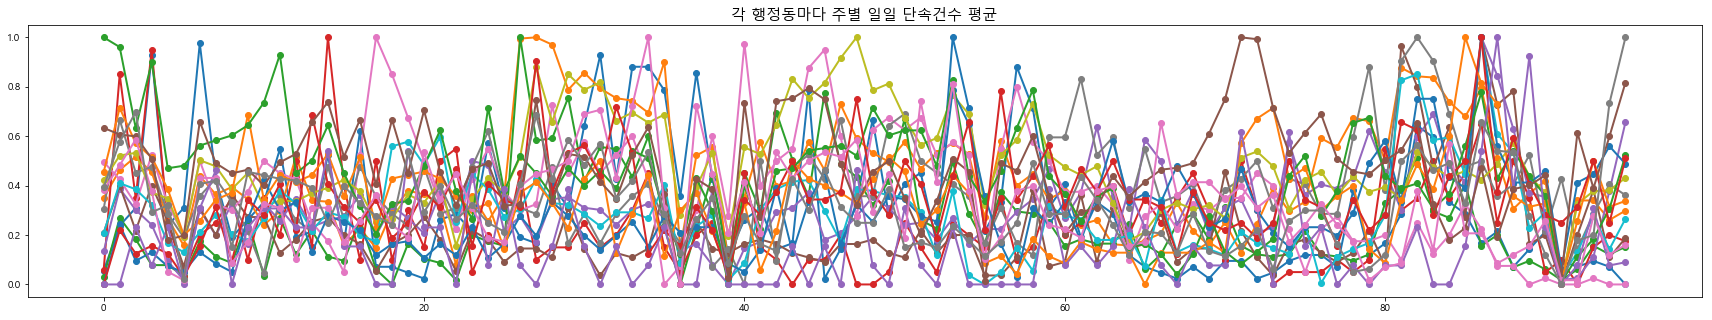

In [41]:
plt.figure(figsize=(30,5))
for i in range(len(donglist)):
    plt.plot(np.array(bb_me[bb_me['행정동'] == donglist[i]]['일일단속건수_minmax']),marker='o', linewidth=2)
plt.title('각 행정동마다 주별 일일 단속건수 평균', fontsize=15)
plt.show()

---
# 2. 분석
* 행정동별로 계층적 클러스터링(hierarchical clustering)을 진행한 후, 각 클러스터마다 특성을 과거와 현재 추세 등을 비교하여 현재 우선적으로 주차장이 필요해보이는 클러스터를 선택한다.

> **Hierarchical 클러스터링이란?**<br>
>* 단계별로 계층을 따라가며 최종적으로 하나의 케이스가 될 때까지 비슷한 군집끼리 묶음<br>
>* 클러스터의 개수를 미리 지정하지 않아도 됨<br>
>* Dendrogram이라는 트리 모양으로 나타남

>> **거리 측정 방법**<br>
* Single : 한 군집의 점과 다른 군집의 점 사이 가장 짧은 거리
* Complete : 한 군집의 점과 다른 군집의 점 사이 가장 긴 거리
* Average : 한 군집의 점과 다른 군집의 점 사이 평균 거리
* Centroid : 한 군집의 점과 다른 군집의 점 사이 중심 간의 거리
* <span style= "color : red">**Ward** : 두 군집 내 편차들의
제곱합을 기반으로 측정<br> -> 이상치나 노이즈에 덜 민감하여 ward 연결법으로 선정</span>

#### * 주별 일일 단속건수의 평균을 전반적인 추세를 조금 더 강하게 파악하기 위해 `이동 평균을 사용한 다음 MinMax Scaling으로 정규화`

In [43]:
bb_me['이동평균_건수'] = bb_me.groupby('행정동').rolling(window=3, min_periods=1).mean().reset_index()['일일단속건수']

In [44]:
# 행정동별로 MinMax Scaling하는 함수
def get_scale(Data, target1):
    Data[target1 + "_minmax"] = np.zeros(Data.shape[0])
    
    for kind in Data['행정동'].unique():
        temp = Data[Data['행정동'] == kind].copy()
        temp[target1 + "_minmax"]  = temp[target1].transform(lambda x:(x-x.min())/(x.max()-x.min()))
        index = temp.index
        Data.loc[index,target1 + "_minmax"] = temp[target1 + "_minmax"]
    
    return Data

In [45]:
bb_me = get_scale(bb_me, '이동평균_건수') 

In [46]:
bb_me.head()

,행정동,주,일일단속건수,일일단속건수_minmax,이동평균_건수,이동평균_건수_minmax
0,교동,1,0.333333,0.055556,0.333333,0.019608
1,교동,2,1.428571,0.238095,0.880952,0.132353
2,교동,3,1.857143,0.309524,1.206349,0.199346
3,교동,4,5.571429,0.928571,2.952381,0.558824
4,교동,5,1.428571,0.238095,2.952381,0.558824


In [47]:
bb_mss = bb_me.copy()
bb_mss.drop(["일일단속건수", "일일단속건수_minmax"], axis=1)

,행정동,주,이동평균_건수,이동평균_건수_minmax
0,교동,1,0.333333,0.019608
1,교동,2,0.880952,0.132353
2,교동,3,1.206349,0.199346
3,교동,4,2.952381,0.558824
4,교동,5,2.952381,0.558824
...,...,...,...,...
1723,학성동,92,2.952381,0.096503
1724,학성동,93,2.285714,0.037762
1725,학성동,94,2.809524,0.083916
1726,학성동,95,7.714286,0.516084


#### * Dendrogram으로 시각화한 결과를 참고하여 최종 클러스터 수를 5개로 선정

Text(0,0.5,'클러스터 거리')

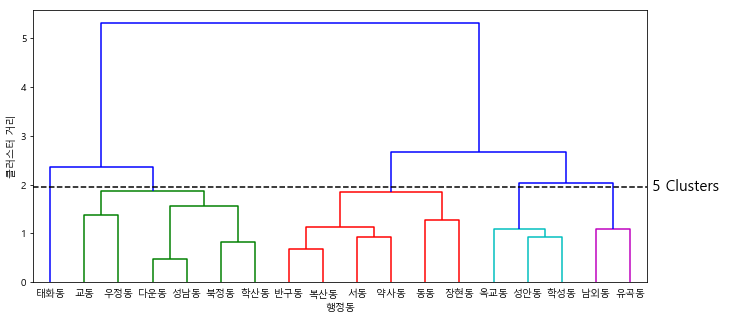

In [48]:
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from tkinter import ttk

corr = pd.pivot(bb_me, index='주', columns='행정동', values='이동평균_건수').corr()
label=corr.columns.get_level_values("행정동")
pdist = sch.distance.pdist(corr)

fig = plt.figure(figsize=(11,5))
ax = fig.add_subplot(1,1,1)

dendd= sch.linkage(pdist, method='ward')
cutoff=0.38*max(dendd[:,2])
dendd2= sch.dendrogram(dendd, color_threshold=cutoff, )
ax.set_xticklabels(label[dendd2["leaves"]], minor=False, fontdict={'size':10})
bounds = ax.get_xbound()
ax.plot(bounds, [1.95, 1.95], '--', c='k')
ax.text(bounds[1], 1.95, ' 5 Clusters ', va='center', fontdict={'size': 15})
plt.xlabel("행정동")
plt.ylabel("클러스터 거리")

In [49]:
groupdonglist = label[dendd2["leaves"]]
groupdongnum = [1,2,2,2,2,2,2,3,3,3,3,3,3,4,4,4,5,5]

In [50]:
cluster = pd.DataFrame({"행정동" : groupdonglist, "그룹" : groupdongnum})
cluster

,행정동,그룹
0,태화동,1
1,교동,2
2,우정동,2
3,다운동,2
4,성남동,2
5,북정동,2
6,학산동,2
7,반구동,3
8,복산동,3
9,서동,3


In [57]:
cluster_kind = list(cluster[cluster['그룹']==4]['행정동'])
cluster_kind

['옥교동', '성안동', '학성동']

#### * 클러스터별로 클러스터링한 결과 시각화

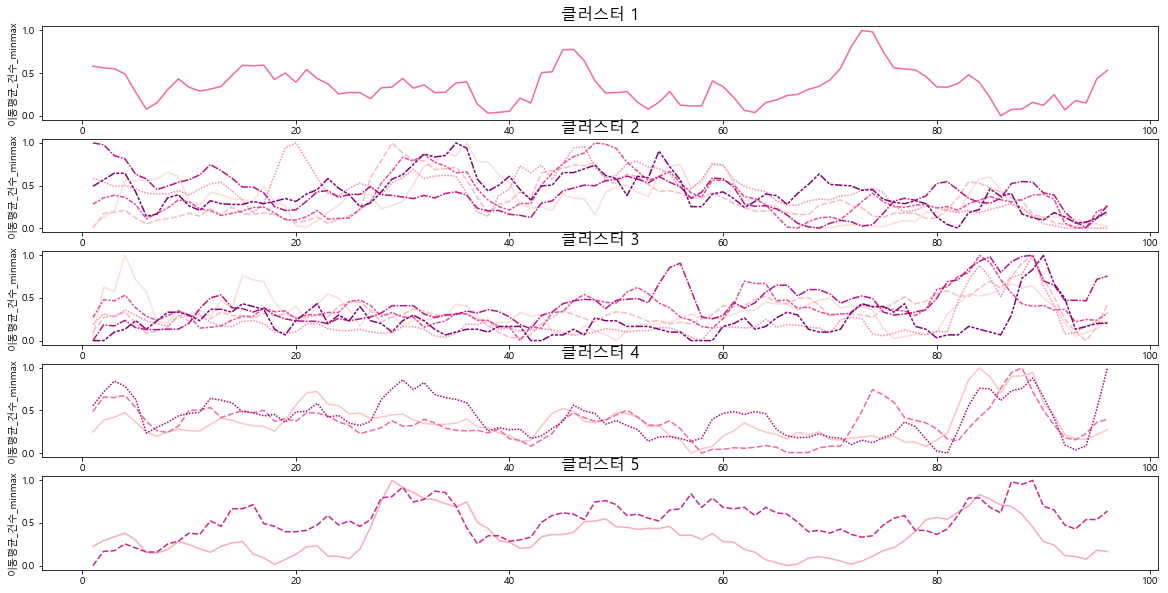

In [55]:
mk = 5
fig,ax = plt.subplots(mk,1,figsize=(20,10))
clulist = ["클러스터 1","클러스터 2","클러스터 3","클러스터 4","클러스터 5"]
for num,i in enumerate(range(1,mk+1)):
    cluster_kind = list(cluster[cluster['그룹']==i]['행정동'])
    temp = bb_me[bb_me['행정동'].isin(cluster_kind)]
    sns.lineplot(temp['주'],temp['이동평균_건수_minmax'],hue=temp['행정동'],ax=ax[num], 
                 style=temp["행정동"],palette=sns.color_palette('RdPu',len(cluster_kind)))
    ax[num].legend().set_visible(False); ax[num].set_xlabel('')
    ax[num].set_title(clulist[i-1], fontsize=16)

In [53]:
from ipywidgets import interact, interact_manual
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
#최종 클러스터 결과

cluster_label = cluster["그룹"].unique()
cluster_label.sort()
cluster_label

category = cluster_label
@interact
def show(col=category):
    fig = go.Figure()
    cluster_kind = list(cluster[cluster['그룹']==col]['행정동'])
    temp_final = bb_me[bb_me['행정동'].isin(cluster_kind)]
    fig=px.line(temp_final, x='주', y='이동평균_건수_minmax', color='행정동', hover_data=['행정동'])
    fig.update_layout(title = '각 행정동별 불법주차 적발건수 추이 클러스터', template='plotly_white',height=450)
    fig.show()

interactive(children=(Dropdown(description='col', options=(1, 2, 3, 4, 5), value=1), Output()), _dom_classes=(…

---
# 3. 결론
- 계층적 클러스터링을 통해서 행정동별 클러스터링을 한 결과, 울산시 중구에서 불법주정차 단속 현황이 비슷한 패턴을 가지고 있는 행정동들이 존재하였고, 각 클러스터 별로 비교를 해보았다.


>- 클러스터 1 : 클러스터 1의 경우는 '태화동'으로 하나만 존재했는데 태화동의 경우는 울산의 상징인 태화강 국가정원이 자리잡고 있다는 것이 특수한 배경이라고 생각하여 피크닉과 같은 특정 계절에 유동인구가 증가할 것으로 예상하였다. 실제로 네이버 검색어 트랜드에 태화강과 피크닉을 함께 검색한 결과 비슷한 양상을 띄고 있는 것을 알 수 있었고 즉, 특정 기간에만 유동 인구가 증가하여 불법주정차 단속 적발 사례가 증가한다고 유추할 수 있었다. 또한 주변에 이미 많은 노상주차장이 확보되어 있어 우선 행정동에서는 제외하였다.


>- 클러스터 2 : 클러스터 2의 경우는 '교동', '우정동', '다운동', '성남동', '북정동', '학산동'으로 묶였는데, 불법주정차 적발 건수가 대체적으로 감소 추세였기 때문에 우선 행정동에서 제외하였다.


>- 클러스터 3 : 클러스터 3의 경우는 '반구동', '복산동', '서동', '약사동', '동동', '장현동'으로 묶였는데, 최근 불법주정차 단속 사례가 증가 추세에 있고, 인구 밀도 대비 주차장이 적은 것으로 확인되어 우선 행정동으로 선정하였다.


>- 클러스터 4 : 클러스터 4의 경우는 '옥교동', '성안동', '학성동'으로 묶였는데, 최근 불법주정차 적발 건수가 증가했지만 일일 단속건수의 평균치가 전반적으로 낮았다. 또한 인구, 주차장 및 주변 제반 시설과의 거리 등을 고려하여 우선 행정동에서 제외하였다.


>- 클러스터 5 : 클러스터 5의 경우는 '남외동', '유곡동'으로 묶였는데, 최근 불법주정차 단속 적발 사례가 증가 추세이고, 주거 인구가 많고 주변 시설 접근성이 높은 것으로 확인되어 우선 행정동으로 선정하였다.

결론적으로 클러스터 1, 클러스터 5에 존재하는 행정동을 우선 행정동을 선정하였다.
